# Testing by solving Maxwell's equations in InSb

Taking data and algorithm from
Yu, Heffernan, and Talbayev [``Beyond the effective mass approximation: A predictive theory of the nonlinear optical response of conduction electrons''](https://doi.org/10.1103/PhysRevB.95.125201) Phys. Rev. B **95**, 125201 (2017)

In [1]:
from BeyoundEffMass import *
from scipy.interpolate import UnivariateSpline
from tqdm.notebook import tqdm

## Loading data for InSb

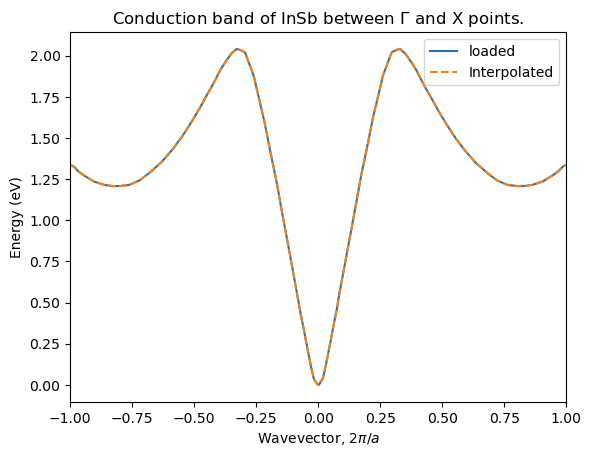

In [2]:
k, E_band = np.loadtxt("energy_xband_InSb.dat").T
# Interpolating

conduction_band = UnivariateSpline(k, E_band, s=0)
a = 0.64794e-9

plt.title(r"Conduction band of InSb between $\Gamma$ and X points.")
plt.plot(k / (2 * np.pi / a), E_band / e, label="loaded")
plt.xlabel(r"Wavevector, $2\pi/a$")
plt.ylabel("Energy (eV)")

plt.plot(k / (2 * np.pi / a), conduction_band(k) / e, "--", label="Interpolated")

plt.xlim(-1, 1)

plt.legend()
plt.show()

Initial pulse

In [3]:
E0 = 100e3 / 1e-2 # ******
f0 = 1e12
τd = 1e-12 #0.5e-12

def Ez_init(x):
    t = x / c
    return E0 * np.exp(-(t / τd) ** 2) * np.sin(2 * np.pi * f0 * t)

In [4]:
x, Δx1 = np.linspace(-25 * c * τd, 3 * c * τd, 2000, retstep=True)

Ez_init = Ez_init(x)

In [5]:
# Note that in the article Δx1 = 5e-6
Δx1

4.199194009004501e-06

In [6]:
# Sample length
d = 0.5e-3

Δx2 = 1.25e-6

Δt = 0.01 * min(Δx1, Δx2) / c

N2 = int(round(d / Δx2))

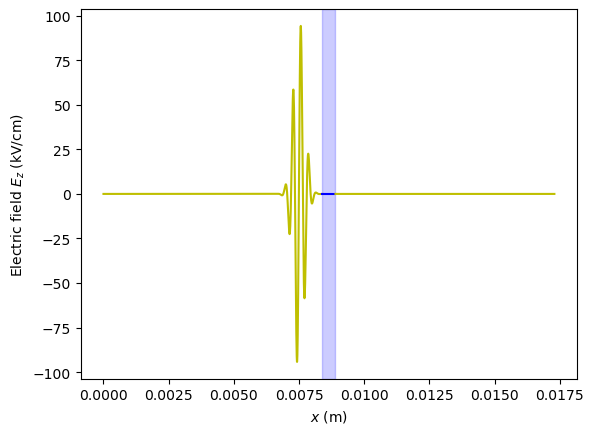

In [7]:
params = dict( 
    Δx1 = Δx1, 
    
    Δx2 = Δx2,
    N2 = N2,
    
    Ez_init = Ez_init, 
    
    diff_E = conduction_band.derivative(), 
    
    epsilon_infty = 15., #15.6,
    γ = 0.5e12,
    n = 7.3e13 / 1e-6,
)

sys = CBeyondEffMass(
    Δt = Δt, 
    **params
)

sys.plot_Ez()

  0%|          | 0/300000 [00:00<?, ?it/s]

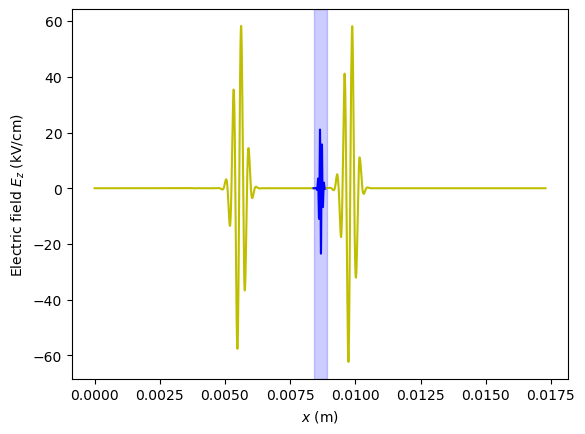

In [8]:
# propagation
n_steps = 300000
t = n_steps * Δt

for _ in tqdm(range(n_steps)):
    sys.single_step_propagation()

sys.plot_Ez()

## Moving backwards in time

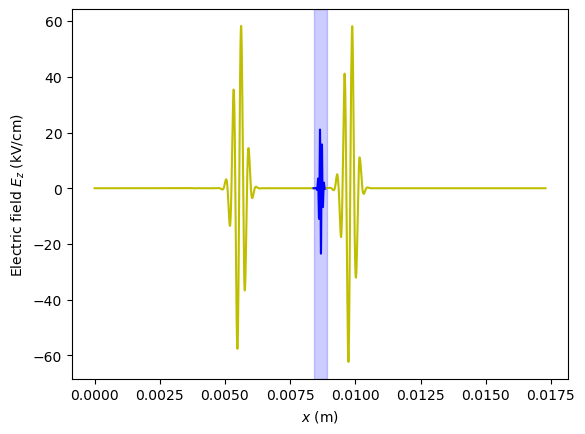

In [9]:
# Copying the propagator

sys_back_in_time = CBeyondEffMass(
    Δt = -Δt, 
    **params
)

sys_back_in_time.Ez1[:] = sys.Ez1
sys_back_in_time.Ez2[:] = sys.Ez2
sys_back_in_time.Ez3[:] = sys.Ez3

sys_back_in_time.Hy1[:] = sys.Hy1
sys_back_in_time.Hy2[:] = sys.Hy2
sys_back_in_time.Hy3[:] = sys.Hy3

sys_back_in_time.Dz2[:] = sys.Dz2

sys_back_in_time.PNL[:] = sys.PNL
sys_back_in_time.k[:] = sys.k

sys_back_in_time.plot_Ez()

  0%|          | 0/300000 [00:00<?, ?it/s]

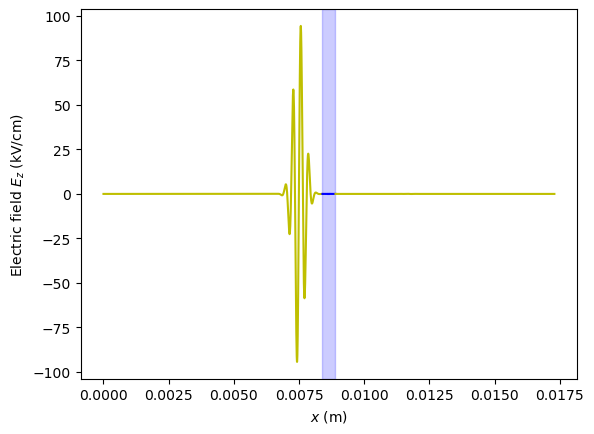

In [10]:
# Propagating backwards in time
for _ in tqdm(range(n_steps)):
    sys_back_in_time.single_step_propagation()

sys_back_in_time.plot_Ez()

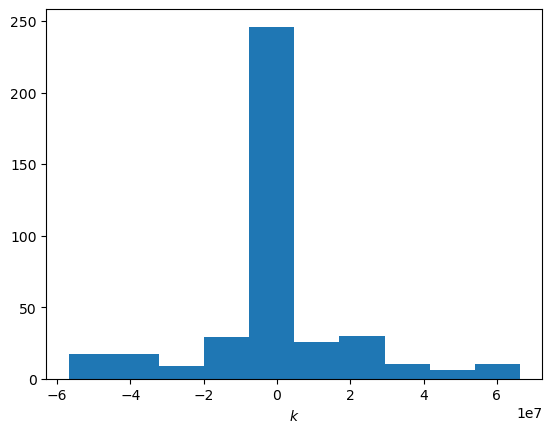

In [11]:
plt.hist(sys_back_in_time.k)
plt.xlabel("$k$")
plt.show()

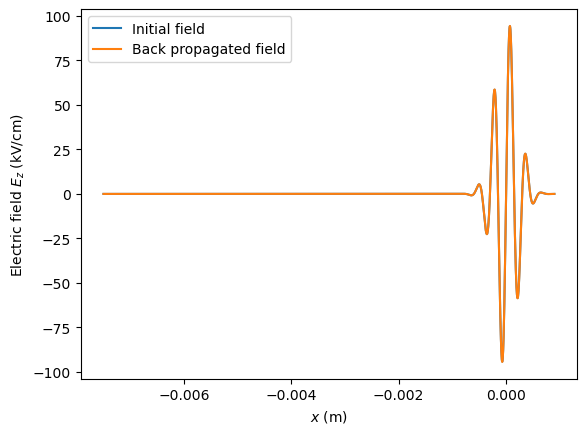

In [12]:
plt.plot(x, Ez_init / 1e5, label="Initial field")
plt.plot(x, sys_back_in_time.Ez1 / 1e5, label="Back propagated field")

plt.xlabel("$x$ (m)")
plt.ylabel("Electric field $E_z$ (kV/cm)")

plt.legend()
plt.show()

## Comparing the incident and transmitted electric fields

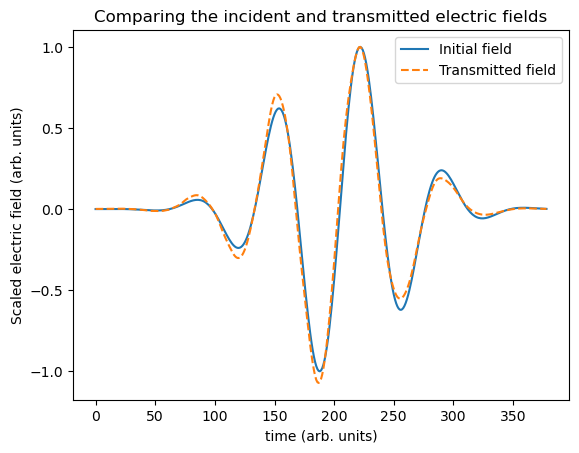

In [13]:
def shift_and_scale(E):
    """
    Scale the electric field to max and shift it to the center
    """
    field = np.roll(E, int(E.size / 2) - E.argmax()) / E.max()
    indx = np.nonzero(np.abs(field) > 1e-3)[0]
    
    return field, indx[0], indx[-1]

field_init, low_init, upper_init = shift_and_scale(Ez_init)
field_trans, low_trans, upper_trans = shift_and_scale(sys.Ez3)

low = min(low_init, low_trans)
upper = max(upper_init, upper_trans)

plt.plot(
    field_init[low:upper],
    label = "Initial field"
)

plt.plot(
    field_trans[low:upper],
    "--",
    label = "Transmitted field"
)

plt.legend()
plt.title("Comparing the incident and transmitted electric fields")
plt.xlabel("time (arb. units)")
plt.ylabel("Scaled electric field (arb. units)")
plt.show()